# TODO:
- Next: Refine ML Modeling
-

# Introduction

This project aims to develop a set of predictive model for monitoring and optimizing water quality in freshwater aquaponics systems dedicated to catfish farming. By leveraging IoT sensor data and machine learning techniques, we analyze key environmental and biological factors influencing water health and fish well-being. Our system integrates real-time data collection from twelve aquaponics ponds, each monitored by an ESP-32 microcontroller equipped with sensors measuring parameters such as turbidity, temperature, ammonia, nitrate, dissolved oxygen, and pH.

The *Sensor Based Aquaponics Fish Pond Datasets*$\text{}^{1}$ consists of time-series records spanning from June to mid-October 2021, collected from twelve aquaponics ponds. Each pond is monitored individually, with IoT units capturing data every five minutes. These measurements provide insights into the complex interactions between water conditions and fish health, enabling predictive analytics for early issue detection and improved aquaponics management.

Key Variables in the Dataset:

- **Date/Time:** Timestamp of the recorded data.
- **Temperature:** Water temperature in degrees Celsius.
- **Turbidity:** Cloudiness or haziness of the water due to suspended particles.
- **Dissolved Oxygen (DO):** Oxygen available in water, essential for fish respiration and aerobic microbial processes.
- **pH:** Acidity or alkalinity of the water, crucial for maintaining optimal conditions.
- **Ammonia:** Concentration of ammonia, a byproduct of fish waste and organic matter decomposition.
- **Nitrate:** End-product of the nitrification process, impacting plant and microbial interactions.
- **Fish Population:** Number of fish in the pond at the time of measurement.
- **Fish Length:** Length of individual fish, indicating growth trends.
- **Fish Weight:** Mass of individual fish, reflecting health and development.

# Library Imports and Functions

In [ ]:
# import necessary libraries
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.sm_exceptions import DomainWarning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import warnings

pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings('ignore', category=FutureWarning, module='statsmodels.genmod.families.links')
warnings.filterwarnings("ignore", category=DomainWarning)

# Data Loading and Initial Overview

In [ ]:
# load IoT dataset
# pond1_raw = pd.read_csv('data/archive/IoTPond1.csv')
pond1_raw = pd.read_csv('/content/IoTpond1.csv')


In [ ]:
pond1_raw.head()

,created_at,entry_id,Temperature (C),Turbidity(NTU),Dissolved Oxygen(g/ml),PH,Ammonia(g/ml),Nitrate(g/ml),Population,Fish_Length(cm),Fish_Weight(g)
0,2021-06-19 00:00:05 CET,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
1,2021-06-19 00:01:02 CET,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2,2021-06-19 00:01:22 CET,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
3,2021-06-19 00:01:44 CET,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
4,2021-06-19 00:02:07 CET,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


In [ ]:
pond1_raw.shape

(83126, 11)

In [ ]:
pond1_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83126 entries, 0 to 83125
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   created_at              83126 non-null  object 
 1   entry_id                83126 non-null  int64  
 2   Temperature (C)         83126 non-null  float64
 3   Turbidity(NTU)          83126 non-null  int64  
 4   Dissolved Oxygen(g/ml)  83126 non-null  float64
 5   PH                      83126 non-null  float64
 6   Ammonia(g/ml)           83074 non-null  float64
 7   Nitrate(g/ml)           83126 non-null  int64  
 8   Population              83126 non-null  int64  
 9   Fish_Length(cm)         83124 non-null  float64
 10  Fish_Weight(g)          83124 non-null  float64
dtypes: float64(6), int64(4), object(1)
memory usage: 7.0+ MB


# Data Cleaning

In [ ]:
# create a deep copy of the raw data
pond1 = pond1_raw.copy()

In [ ]:
# convert 'created_at' to datetime format
pond1['created_at'] = pd.to_datetime(pond1['created_at'], errors='coerce')

<ipython-input-10-2aa90c986577>:2: FutureWarning: Parsed string "2021-06-19 00:00:05 CET" included an un-recognized timezone "CET". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  pond1['created_at'] = pd.to_datetime(pond1['created_at'], errors='coerce')


In [ ]:
# rename columns for easy reference
pond1.rename(columns={
    'created_at': 'datetime',
    'Temperature (C)': 'temperature',
    'Turbidity(NTU)': 'turbidity',
    'Dissolved Oxygen(g/ml)': 'dissolved_oxygen',
    'PH':'ph',
    'Ammonia(g/ml)': 'ammonia',
    'Nitrate(g/ml)': 'nitrate',
    'Population': 'population',
    'Fish_Length(cm)': 'fish_length',
    'Fish_Weight(g)': 'fish_weight'
}, inplace=True)

# set 'datetime' as the index for time-series analysis
pond1.set_index('datetime', inplace=True)

In [ ]:
# replace missing values with column-wise mean
pond1.fillna(pond1.mean(), inplace=True)

<Axes: >

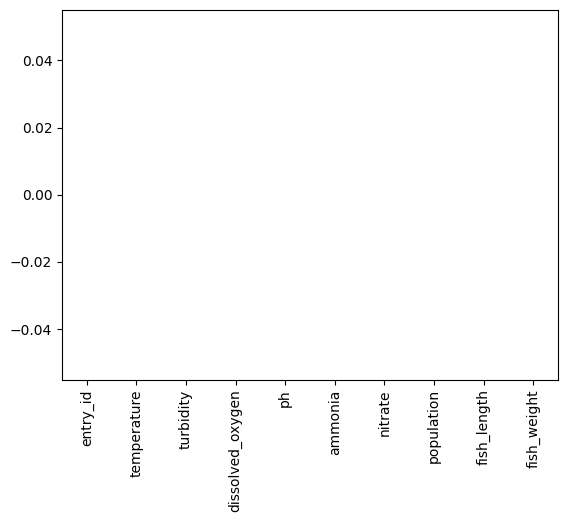

In [ ]:
pond1.isna().sum().plot.bar()

In [ ]:
pond1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 83126 entries, 2021-06-19 00:00:05 to 2021-10-13 04:14:22
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   entry_id          83126 non-null  int64  
 1   temperature       83126 non-null  float64
 2   turbidity         83126 non-null  int64  
 3   dissolved_oxygen  83126 non-null  float64
 4   ph                83126 non-null  float64
 5   ammonia           83126 non-null  float64
 6   nitrate           83126 non-null  int64  
 7   population        83126 non-null  int64  
 8   fish_length       83126 non-null  float64
 9   fish_weight       83126 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 7.0 MB


In [ ]:
pond1.head()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
datetime,,,,,,,,,,
2021-06-19 00:00:05,1889,24.8750,100,4.505,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:01:02,1890,24.9375,100,6.601,8.43818,0.45842,194,50,7.11,2.91
2021-06-19 00:01:22,1891,24.8750,100,15.797,8.42457,0.45842,192,50,7.11,2.91
2021-06-19 00:01:44,1892,24.9375,100,5.046,8.43365,0.45842,193,50,7.11,2.91
2021-06-19 00:02:07,1893,24.9375,100,38.407,8.40641,0.45842,192,50,7.11,2.91


# Exploratory Data Analysis (EDA)

In [ ]:
pond1.describe()

,entry_id,temperature,turbidity,dissolved_oxygen,ph,ammonia,nitrate,population,fish_length,fish_weight
count,83126.000000,83126.000000,83126.000000,83126.000000,83126.000000,8.312600e+04,83126.000000,83126.0,83126.000000,83126.000000
mean,84018.144516,24.573376,87.490160,12.390251,7.518329,2.030817e+08,458.294408,50.0,16.414686,44.568470
std,53579.484245,0.861532,25.859375,12.518253,0.534787,7.863770e+09,338.313206,0.0,5.272180,33.215091
min,1889.000000,-127.000000,1.000000,0.007000,-0.586270,6.770000e-03,45.000000,50.0,7.110000,2.910000
25%,24902.250000,24.125000,91.000000,3.440000,7.153520,4.584200e-01,146.000000,50.0,11.790000,14.190000
50%,103478.500000,24.562500,100.000000,7.133000,7.357790,6.139700e-01,347.000000,50.0,18.080000,54.700000
75%,131074.750000,24.937500,100.000000,15.819000,7.838980,1.565161e+01,823.000000,50.0,21.000000,67.520000
max,247405.000000,27.750000,100.000000,41.046000,8.551670,4.270000e+11,1936.000000,50.0,33.450000,318.640000


### Define variables

In [ ]:
# define the variables
# without population since its a contant value
vars = ['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight']

### Histograms and Readings

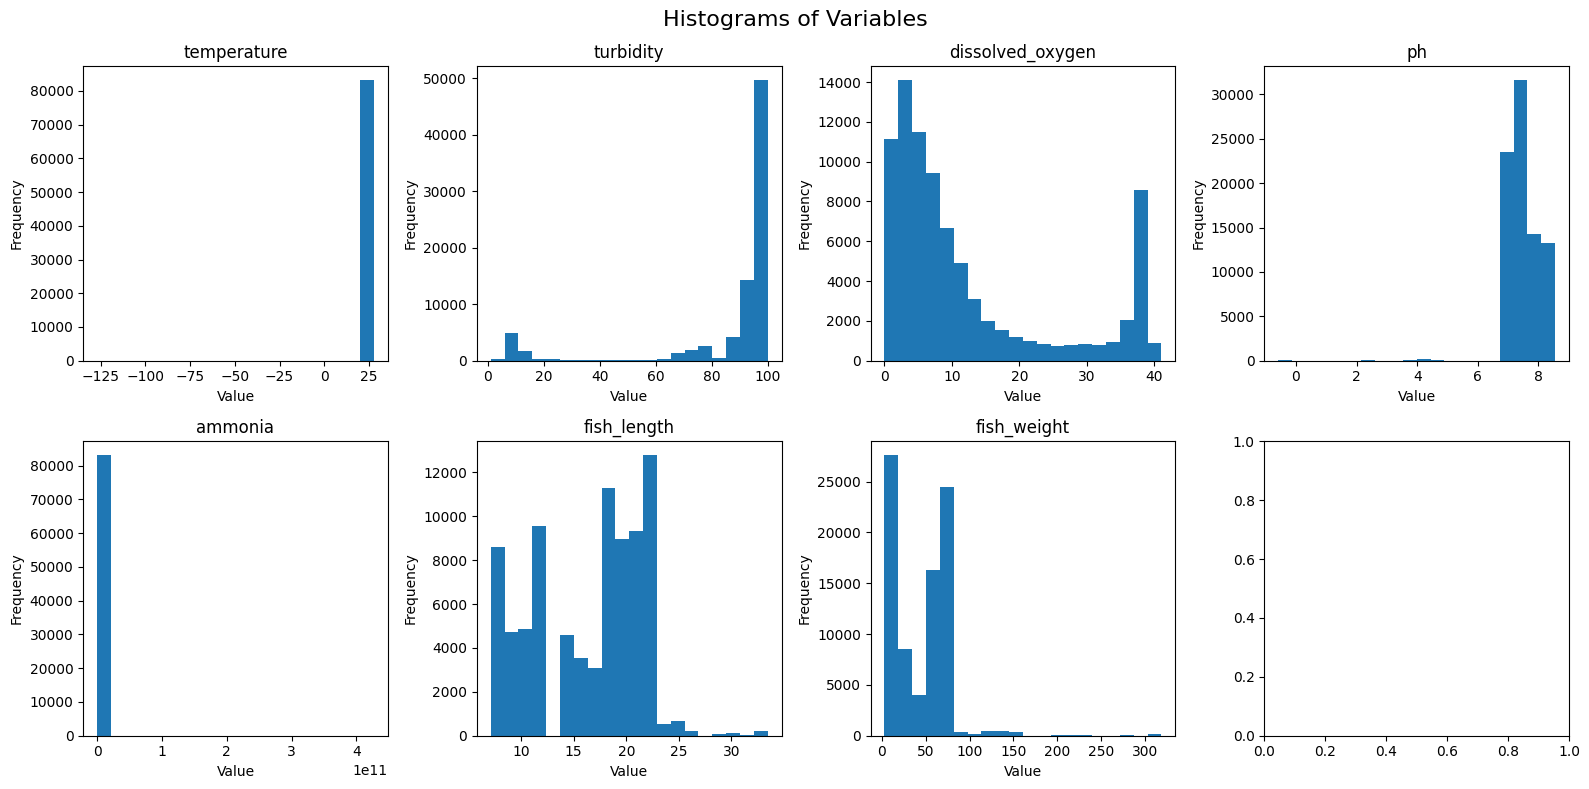

In [ ]:
# set grid and size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
fig.suptitle("Histograms of Variables", fontsize=16)

# flatten axes for easy iteration
axes = axes.flatten()

# create each histogram
for i, col in enumerate(vars):
    axes[i].hist(pond1[col], bins=20)
    axes[i].set_title(col)
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# adjusts spacing
plt.tight_layout()
plt.show()

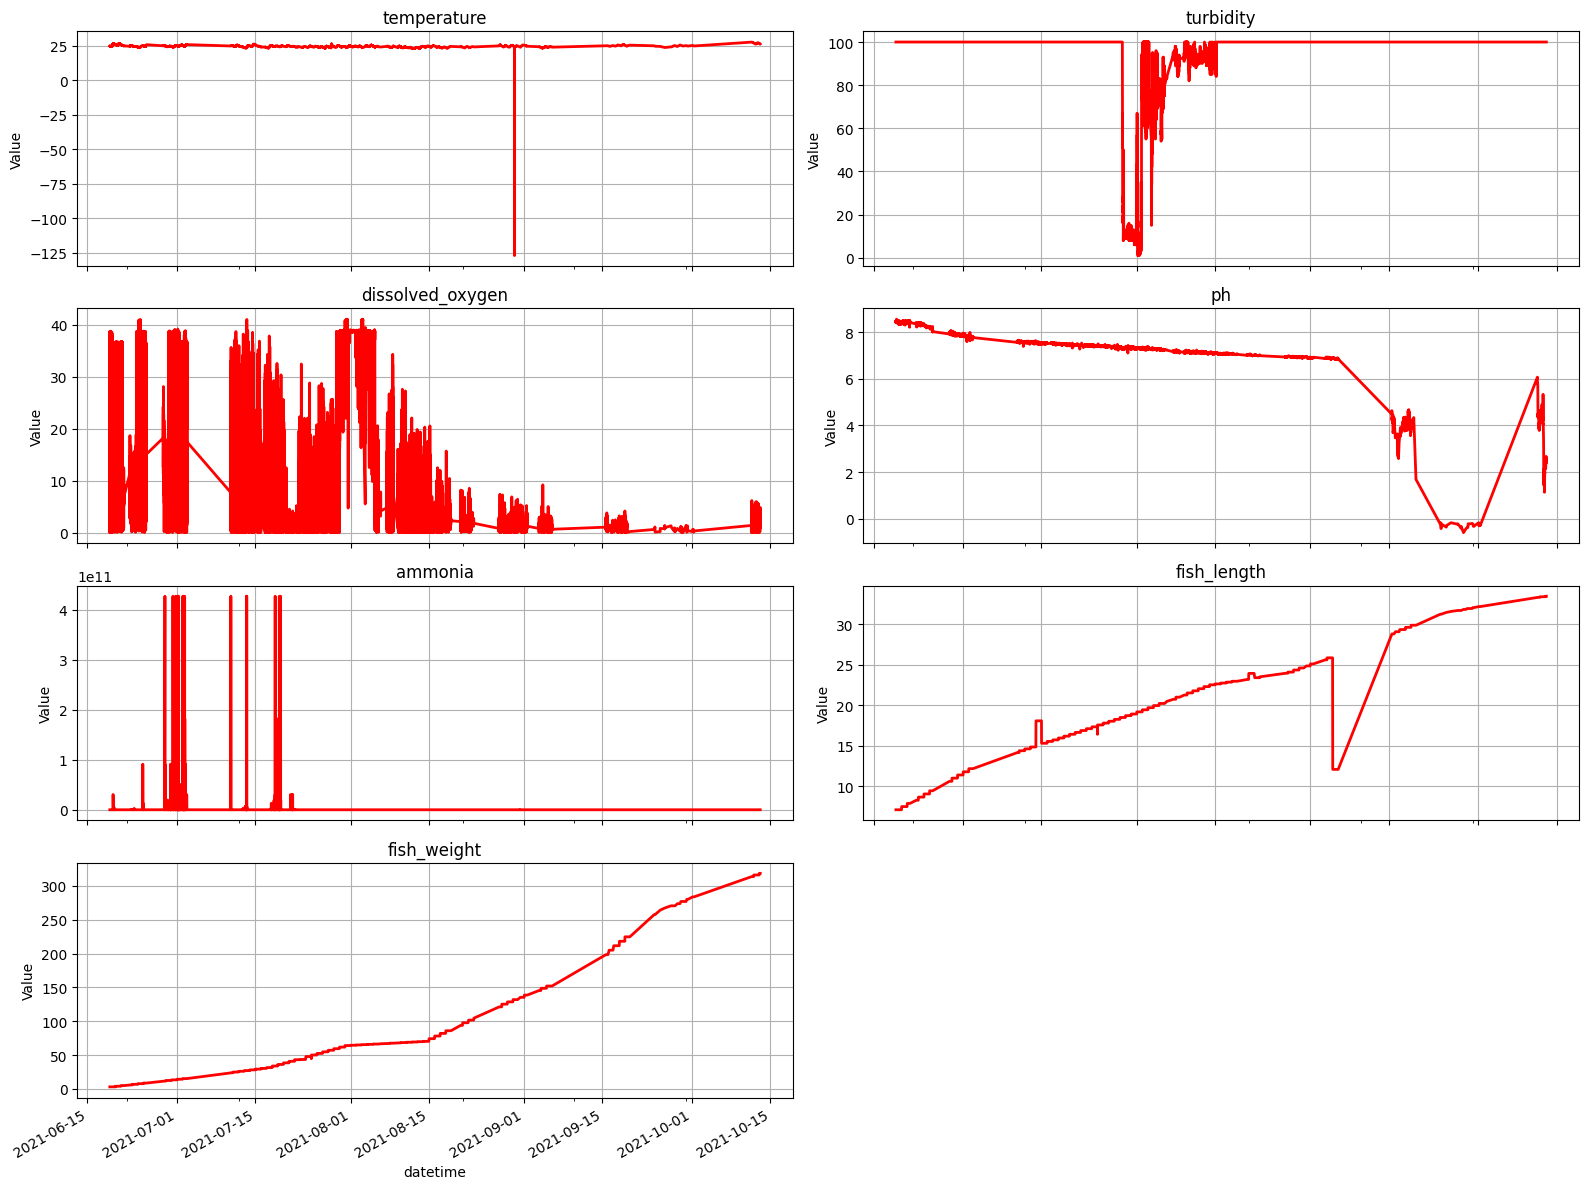

In [ ]:
# set grid and size
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12), sharex=True)

# flatten axes for easy iteration
axes = axes.flatten()

# create subplots for each variables
for i, col in enumerate(vars):
    pond1[col].plot(ax=axes[i], title=col, linewidth=2, color='red')
    axes[i].set_ylabel("Value")
    axes[i].grid(True)  # add grid for better readability

# remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# adjusts spacing
plt.tight_layout()
plt.show()

### Monthly Average

In [ ]:
# group by 'datetime' with monthly frequency
pond1_monthly_avg = pond1.groupby(pd.Grouper(freq='M'))[vars].mean()
pond1_monthly_avg.head()

<ipython-input-20-29dd57bcfcbb>:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pond1_monthly_avg = pond1.groupby(pd.Grouper(freq='M'))[vars].mean()


,temperature,turbidity,dissolved_oxygen,ph,ammonia,fish_length,fish_weight
datetime,,,,,,,
2021-06-30,25.011444,100.000000,10.323498,8.193054,1.441780e+08,9.082526,7.664294
2021-07-31,24.680985,78.991333,14.254337,7.513028,4.698885e+08,15.858532,37.591927
2021-08-31,24.181719,87.036533,12.282984,7.156489,6.961168e+03,21.327552,70.045617
2021-09-30,24.495140,100.000000,1.230838,5.738375,5.995124e+00,23.662442,172.551820
2021-10-31,26.832014,100.000000,1.578326,3.642498,8.847973e+00,33.333122,314.855113


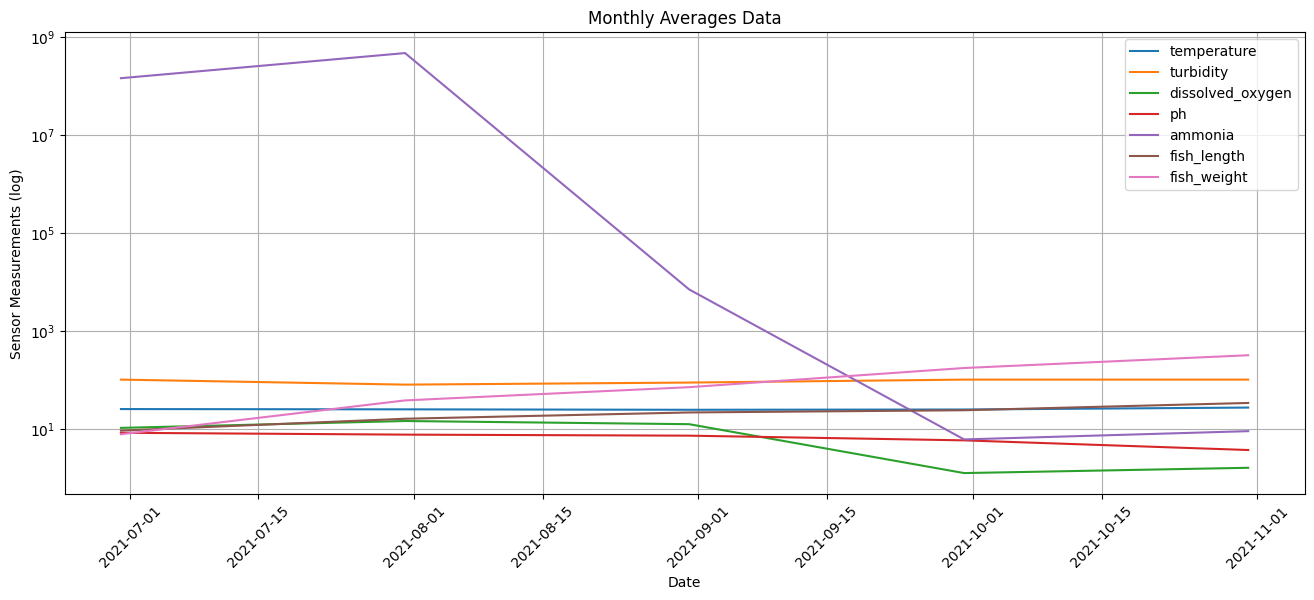

In [ ]:
# plot each variable
plt.figure(figsize=(16, 6))
for column in vars:
    plt.plot(pond1_monthly_avg.index,  # months
             pond1_monthly_avg[column],  # monthly average
             label=column)

plt.title('Monthly Averages Data')
plt.xlabel('Date')
plt.ylabel('Sensor Measurements (log)')
plt.yscale('log')  # log scale for readability
plt.legend()
plt.xticks(rotation=45)  # for better visibility
plt.grid(True)
plt.show()

### Data Correlation

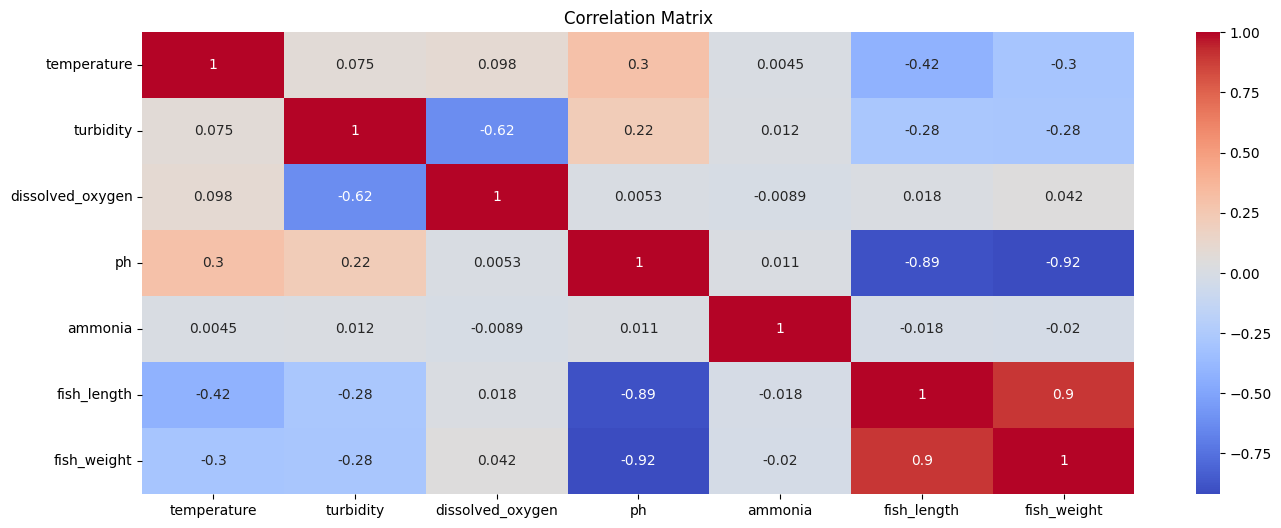

In [ ]:
# compute correlation matrix
corr_matrix = pond1[vars].corr()

# display heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Feature Selection

In [ ]:
# Define reasonable thresholds for key features
pond1_clean = pond1[(pond1['temperature'] > -10) & (pond1['temperature'] < 40)]  # Valid temperature range
pond1_clean = pond1_clean[(pond1_clean['ammonia'] > 0) & (pond1_clean['ammonia'] < 1000)]  # Realistic ammonia range
pond1_clean = pond1_clean[(pond1_clean['dissolved_oxygen'] > 1) & (pond1_clean['dissolved_oxygen'] < 20)]  # Normal DO range

# Remove zero variance columns
pond1_clean = pond1_clean.drop(columns=['population'])  # Removing the constant value column

In [ ]:
# Fill missing values using interpolation
pond1_clean.interpolate(method='linear', inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
pond1_scaled = pond1_clean.copy()
pond1_scaled[['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight']] = scaler.fit_transform(
    pond1_clean[['temperature', 'turbidity', 'dissolved_oxygen', 'ph', 'ammonia', 'fish_length', 'fish_weight']]
)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)  # Retain 5 components
pca_features = pca.fit_transform(pond1_scaled)

# Convert PCA output back into DataFrame
pca_df = pd.DataFrame(pca_features, columns=[f'PC{i+1}' for i in range(5)], index=pond1_scaled.index)

In [ ]:
# Convert DataFrame to numpy array
seq_length = 30  # Use past 30 readings to predict the next value
data = pond1_scaled.values

X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length, -1])  # Predict fish weight

X, y = np.array(X), np.array(y)

# Machine Learning Models

## Traditional

In [ ]:
#Regression

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

# X shape: (num_samples, sequence_length, num_features)
# y shape: (num_samples,)

# Split data into training and testing sets
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Define an Input layer
input_layer = Input(shape=(X.shape[1], X.shape[2]))
x = LSTM(128, activation='tanh', return_sequences=True)(input_layer)
x = Dropout(0.2)(x)
x = LSTM(64, activation='tanh')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
output_layer = Dense(1)(x)  # Regression output (e.g., predicting fish weight)
model_lstm = Model(inputs=input_layer, outputs=output_layer)
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.summary()

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the LSTM model
history_lstm = model_lstm.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 30, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 128)             │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.6483 - mae: 0.7553 - val_loss: 2.7660 - val_mae: 1.3397
Epoch 2/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6425 - mae: 0.7559 - val_loss: 2.7785 - val_mae: 1.3444
Epoch 3/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6405 - mae: 0.7544 - val_loss: 2.7896 - val_mae: 1.3485
Epoch 4/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6438 - mae: 0.7578 - val_loss: 2.8809 - val_mae: 1.3819
Epoch 5/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6446 - mae: 0.7580 - val_loss: 2.8033 - val_mae: 1.3536
Epoch 6/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6431 - mae: 0.7568 - val_loss: 2.8032 - val_mae: 1.3535
Epoch 7/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6397 - mae: 0.7534 - val_loss: 2.8454 - val_mae: 1.3690
Epoch 8/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.6426 - mae: 0.7563 - val_loss: 2.7540 - val_mae: 1.3352
Epoch 9/20
1307/1307 ━━━━━━━━━━━

## Deep Learning

In [ ]:
# Convert DataFrame to numpy array
seq_length = 30  # Use past 30 readings to predict the next value
data = pond1_scaled.values

X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])
    y.append(data[i + seq_length, -1])  # Predict fish weight

X, y = np.array(X), np.array(y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()
model_lstm.add(LSTM(128, activation='tanh', return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(64, activation='tanh'))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(1))  # Predicting fish weight
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 128)             │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,177 (477.25 KB)

 Trainable params: 122,177 (477.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, backend as K

# Define latent dimensions and input parameters.
latent_dim = 10
seq_length = X.shape[1]
num_features = X.shape[2]
original_dim = seq_length * num_features

# Build the Encoder
vae_input = layers.Input(shape=(seq_length, num_features))
x = layers.Flatten()(vae_input)
x = layers.Dense(128, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch, latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(vae_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Build the Decoder
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(128, activation='relu')(latent_inputs)
x = layers.Dense(original_dim, activation='sigmoid')(x)
vae_output = layers.Reshape((seq_length, num_features))(x)
decoder = Model(latent_inputs, vae_output, name='decoder')
decoder.summary()

# Define a custom VAE model that returns only the reconstruction.
class VAEModel(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        # Forward pass: encode and decode.
        _, _, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    def train_step(self, data):
        # Unpack data (ignore labels, VAE is unsupervised).
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Compute encoder outputs.
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # Flatten inputs and outputs.
            inputs_flat = tf.reshape(data, (-1, original_dim))
            outputs_flat = tf.reshape(reconstruction, (-1, original_dim))
            # Reconstruction loss: sum of squared differences.
            reconstruction_loss = tf.reduce_sum(tf.square(inputs_flat - outputs_flat), axis=-1)
            # KL divergence loss.
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
            total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        # Compute gradients and update weights.
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
        return {"loss": total_loss}

# Instantiate and compile the VAE model.
vae_model = VAEModel(encoder, decoder)
# Pass loss=None since we override train_step.
vae_model.compile(optimizer='adam', loss=None)
vae_model.summary()

# Train the VAE model using X_train as both input and target.
history_vae = vae_model.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 30, 9)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 270)            │              0 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 128)            │         34,688 │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 10)             │          1,290 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 10)             │          1,290 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z (Lambda)                │ (None, 10)             │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 37,268 (145.58 KB)

 Trainable params: 37,268 (145.58 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 128)                 │           1,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 270)                 │          34,830 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_8 (Reshape)                  │ (None, 30, 9)               │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,238 (141.55 KB)

 Trainable params: 36,238 (141.55 KB)

 Non-trainable params: 0 (0.00 B)

Model: "vae_model_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Functional)                 │ ((None, 10), (None, 10),    │          37,268 │
│                                      │ (None, 10))                 │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Functional)                 │ (None, 30, 9)               │          36,238 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,506 (287.13 KB)

 Trainable params: 73,506 (287.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1307/1307 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: nan

ValueError: No loss to compute. Provide a `loss` argument in `compile()`.

# Model Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate LSTM model
y_pred_lstm = model_lstm.predict(X_test)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print("LSTM Performance:")
print("MSE: {:.4f}".format(mse_lstm))
print("RMSE: {:.4f}".format(rmse_lstm))
print("R²: {:.4f}".format(r2_lstm))

# Evaluate VAE model for anomaly detection using reconstruction error
vae_reconstructions = vae.predict(X_test)
mse_vae = mean_squared_error(X_test.reshape(X_test.shape[0], -1),
                               vae_reconstructions.reshape(X_test.shape[0], -1))
rmse_vae = np.sqrt(mse_vae)

print("\nVAE Performance:")
print("MSE (reconstruction error): {:.4f}".format(mse_vae))
print("RMSE (reconstruction error): {:.4f}".format(rmse_vae))

# Model Deployment

In [ ]:
import time

def get_latest_sensor_data():
    """
    Simulated function to get the latest sensor data.
    Returns a NumPy array of shape (1, sequence_length, num_features).
    """
    # Randomly sample one sequence from X_test
    idx = np.random.randint(0, X_test.shape[0])
    return X_test[idx:idx+1]

# Set a threshold for anomaly detection based on VAE reconstruction error
anomaly_threshold = 0.05

def process_and_predict():
    # Get new data sample
    new_data = get_latest_sensor_data()

    # Predict fish weight using LSTM model
    weight_prediction = model_lstm.predict(new_data)

    # Obtain VAE reconstruction and compute reconstruction error
    reconstruction = vae.predict(new_data)
    rec_error = np.mean((new_data - reconstruction)**2)

    # Check for anomaly
    is_anomaly = rec_error > anomaly_threshold

    return weight_prediction, rec_error, is_anomaly

# Simulate a real-time loop
while True:
    weight_pred, error, anomaly_flag = process_and_predict()
    print("Predicted Fish Weight: {:.2f}".format(weight_pred[0][0]))
    print("VAE Reconstruction Error: {:.4f}".format(error))
    if anomaly_flag:
        print("Anomaly detected! Check water quality/fish health parameters.")
    else:
        print("System operating normally.")

    # Wait for the next data acquisition (simulate 5-minute intervals)
    time.sleep(5)

# Data Export


----------------
$^{1}$ Ogbuokiri, B. (2021). Sensor-based aquaponics fish pond datasets. Kaggle. https://www.kaggle.com/datasets/ogbuokiriblessing/sensor-based-aquaponics-fish-pond-datasets